In [145]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt 
import seaborn as sns; sns.set(style='whitegrid')

from sklearn.model_selection import GridSearchCV, validation_curve, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler 
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

from scipy import stats 

/kaggle/input/eergy-efficiency-dataset/ENB2012_data.csv


In [146]:
df = pd.read_csv(r'/kaggle/input/eergy-efficiency-dataset/ENB2012_data.csv')

In [147]:
df.columns

Index(['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'Y1', 'Y2'], dtype='object')

In [148]:
df.dtypes

X1    float64
X2    float64
X3    float64
X4    float64
X5    float64
X6      int64
X7    float64
X8      int64
Y1    float64
Y2    float64
dtype: object

In [149]:
df.isna().sum()

X1    0
X2    0
X3    0
X4    0
X5    0
X6    0
X7    0
X8    0
Y1    0
Y2    0
dtype: int64

The dataset is too clean, that makes me uncomfortable.

<Figure size 1200x800 with 0 Axes>

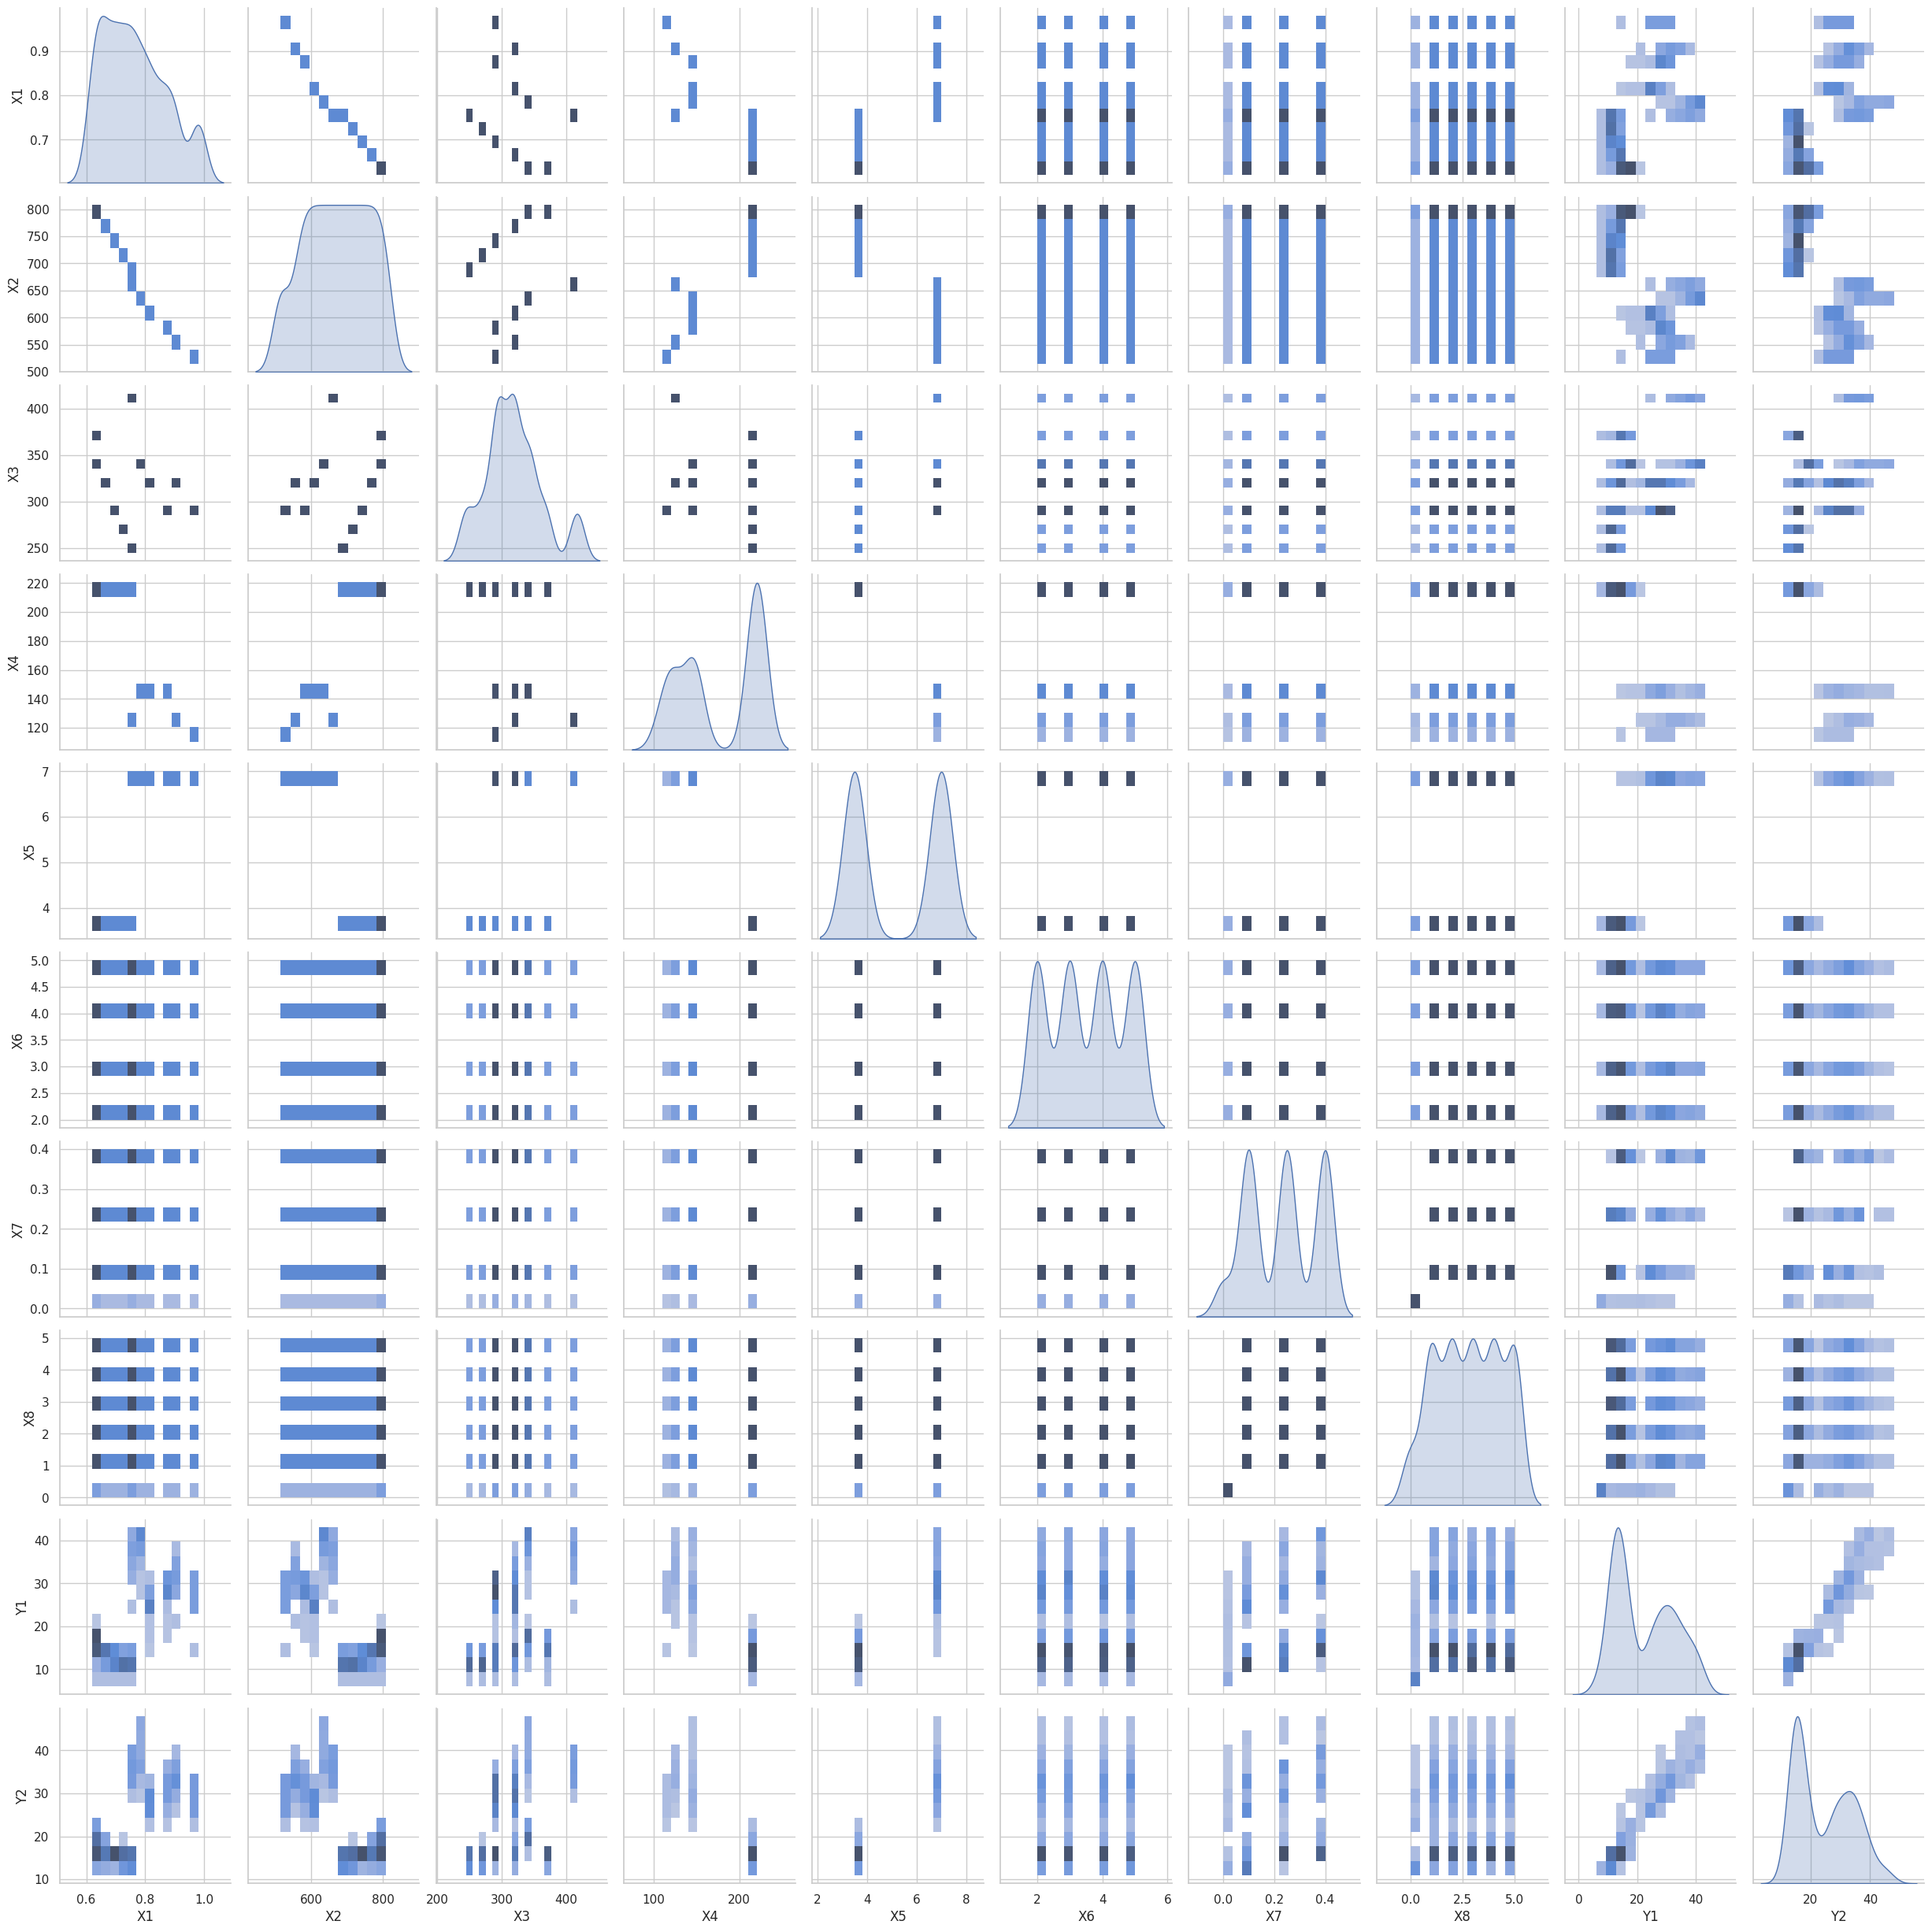

In [150]:
plt.figure(figsize=(12, 8))
sns.pairplot(df, diag_kind='kde', kind='hist')
plt.show()

In [151]:
x_train, x_test, y_train, y_test = train_test_split(df.loc[:, 'X1':'X8'], df.loc[:, 'Y1':'Y2'], test_size=0.8, random_state=42)

In [152]:
z_scores = np.abs(stats.zscore(x_train))
outliers = np.where(z_scores > 3)
print(f"Indices of rows with outliers: {outliers[0]}")

Indices of rows with outliers: []


In [153]:
from sklearn.ensemble import IsolationForest

iso = IsolationForest(contamination=0.05, random_state=42)
outliers_mask = iso.fit_predict(x_train)

x_train_cleaned = x_train[outliers_mask == 1]
y_train_cleaned = y_train[outliers_mask == 1]

print(f'Shape of the array: {x_train.shape}')
print(f'Shape of the cleaned array: {x_train_cleaned.shape}')

Shape of the array: (153, 8)
Shape of the cleaned array: (145, 8)


In [154]:
pca_model = make_pipeline(
    StandardScaler(),
    PCA()
).fit(x_train_cleaned)

I'd like to check the importance of features, if there are not enough features then I gotta add some(do not know yet how)

Text(0, 0.5, 'Cumulative explained variance')

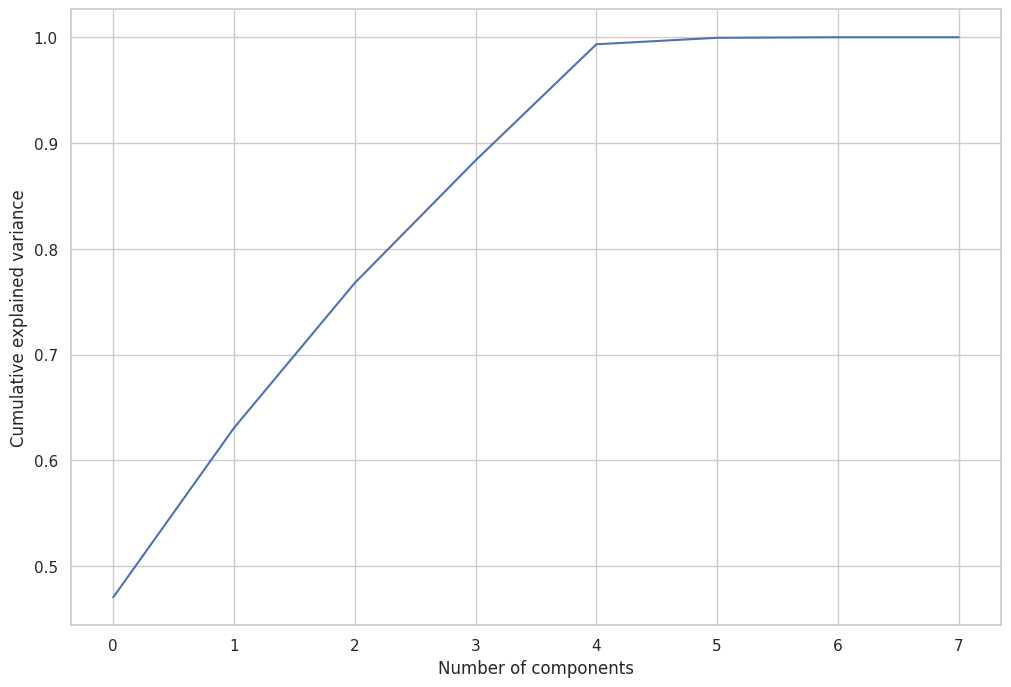

In [155]:
plt.figure(figsize=(12, 8))
plt.plot(np.cumsum(pca_model[1].explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

In [156]:
pca.components_

array([[-1.08735186e-03,  9.01159613e-01,  3.81492399e-02,
         4.31505186e-01, -1.60059031e-02, -3.43015952e-05,
         2.11038415e-04, -1.35833936e-03],
       [-1.93500808e-04,  1.45219734e-01,  9.11984815e-01,
        -3.83382540e-01,  1.43386361e-02,  1.17899612e-03,
        -1.92230952e-04, -2.38611795e-03],
       [-3.08224823e-04,  1.67520830e-03,  2.16414037e-03,
        -2.44466032e-04,  8.44985914e-03, -3.75975433e-02,
         1.89616948e-02,  9.99073488e-01],
       [ 1.36452736e-03, -7.05337782e-04, -3.54129360e-04,
        -1.75604211e-04, -5.07522534e-02,  9.97986811e-01,
        -4.75783711e-04,  3.79972540e-02],
       [-2.14356995e-02,  1.22873992e-02, -1.25230078e-02,
         1.24052035e-02,  9.97935026e-01,  5.10049731e-02,
        -2.37948054e-02, -6.06623609e-03],
       [-7.42851880e-03,  8.92366042e-05, -1.71659155e-04,
         1.30447880e-04,  2.34291060e-02,  2.40461190e-03,
         9.99512892e-01, -1.90797369e-02],
       [ 9.99741042e-01,  1.273838

In [157]:
model = make_pipeline(
    StandardScaler(),
    PCA(n_components=5),
    LinearRegression()
).fit(x_train_cleaned, y_train_cleaned)

y_pred = model.predict(x_test)

print(f'Mean Squared Error: {mean_squared_error(y_test, y_pred)}')
print(f'R^2: {r2_score(y_test, y_pred)}')

Mean Squared Error: 13.659144005516689
R^2: 0.8598577744234921


Good Result, but could it be better?

In [158]:
base_model = make_pipeline(
    StandardScaler(),
    PCA(n_components=5),
    SVR(kernel='linear')
)

multi_model = MultiOutputRegressor(base_model)

params_grid = {
    'estimator__svr__C': [0.1, 1, 10, 100],
    'estimator__svr__epsilon': [0.1, 0.2]
}

grid = GridSearchCV(multi_model, params_grid, cv=5)

%timeit grid.fit(x_train_cleaned, y_train_cleaned)

1.6 s ± 9.93 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [159]:
# print(f'Grid best params: {grid.best_params_}')

model = grid.best_estimator_
y_pred = model.predict(x_test)

print(f'MSE: {mean_squared_error(y_test,y_pred)}')
print(f'R^2: {r2_score(y_test, y_pred)}')

MSE: 14.808282986755202
R^2: 0.8480201296078975


What a waste of time